# Import libraries / Load data

In [329]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [330]:
join_orders_cust_paym_seller_review = pd.read_csv('csv_files/data_clean.csv')

In [331]:
join_orders_cust_paym_seller_review['order_purchase_timestamp'] = pd.to_datetime(join_orders_cust_paym_seller_review['order_purchase_timestamp'])
join_orders_cust_paym_seller_review['order_approved_at'] = pd.to_datetime(join_orders_cust_paym_seller_review['order_approved_at'])
join_orders_cust_paym_seller_review['order_delivered_carrier_date'] = pd.to_datetime(join_orders_cust_paym_seller_review['order_delivered_carrier_date'])
join_orders_cust_paym_seller_review['order_delivered_customer_date'] = pd.to_datetime(join_orders_cust_paym_seller_review['order_delivered_customer_date'])
join_orders_cust_paym_seller_review['order_estimated_delivery_date'] = pd.to_datetime(join_orders_cust_paym_seller_review['order_estimated_delivery_date'])

In [332]:
join_orders_cust_paym_seller_review.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
payment_value                           float64
seller_id                                object
review_score                            float64
dtype: object

# Create a dataframe for segmentation 

* aggregate per seller_id
* feature engineering


In [333]:
last_order_date = join_orders_cust_paym_seller_review['order_purchase_timestamp'].max()
last_order_date

Timestamp('2018-08-29 15:00:37')

In [334]:
seller = join_orders_cust_paym_seller_review.groupby('seller_id', 
                                                     as_index=False).agg(recency_max = ('order_purchase_timestamp', 
                                                                                    lambda x: (last_order_date-x.max()).days ),
                                                                         recency_min = ('order_purchase_timestamp', 
                                                                                    lambda x: (last_order_date-x.min()).days ),
                                                                         frequency = ('order_id', 'count'),
                                                                         monetary_value = ('payment_value', 'mean'),
                                                                         review_score = ('review_score', 'mean'))

In [335]:
seller.head()

,seller_id,recency_max,recency_min,frequency,monetary_value,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,315,336,3,916.020000,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,47,570,195,170.404462,4.025641
2,002100f778ceb8431b7a1020ff7ab48f,139,349,50,43.392800,3.960000
3,003554e2dce176b5555353e4f3555ac8,257,257,1,139.380000,5.000000
4,004c9cd9d87a3c30c522c48c4fc07416,118,579,155,148.647935,4.138710


Recency_max is the number of days since the last order (will help to identify dormant and churn sellers) 

Recency_min is the number of days since the first order 

Frequency is the total number of orders

Monetary_value is the average payment_value per order

Review_score is the average review score

In [336]:
seller.isna().sum()

seller_id         0
recency_max       0
recency_min       0
frequency         0
monetary_value    0
review_score      0
dtype: int64

# EDA

In [337]:
seller.describe()

,recency_max,recency_min,frequency,monetary_value,review_score
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,129.208754,308.336027,32.927609,226.430648,4.161685
std,163.491276,198.037570,105.388418,380.552723,0.788158
min,0.000000,1.000000,1.000000,15.220000,1.000000
25%,12.000000,127.250000,2.000000,82.985000,3.937621
50%,41.000000,292.000000,7.000000,133.785714,4.272727
75%,205.000000,490.000000,22.000000,220.744583,4.666667
max,694.000000,695.000000,1819.000000,6929.310000,5.000000


In [338]:
seller.dtypes

seller_id          object
recency_max         int64
recency_min         int64
frequency           int64
monetary_value    float64
review_score      float64
dtype: object

**Check distribution**

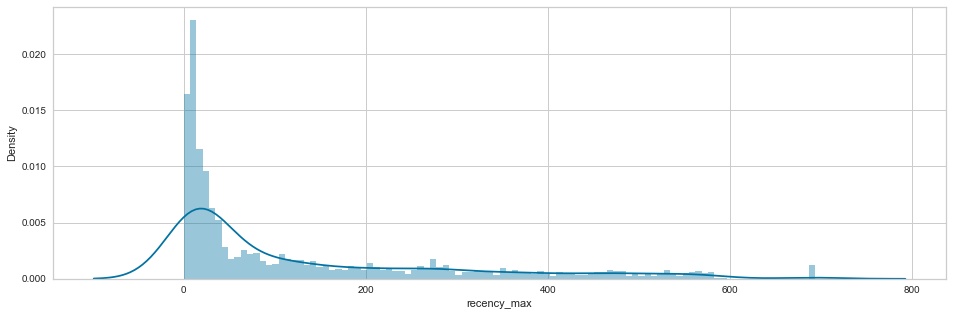

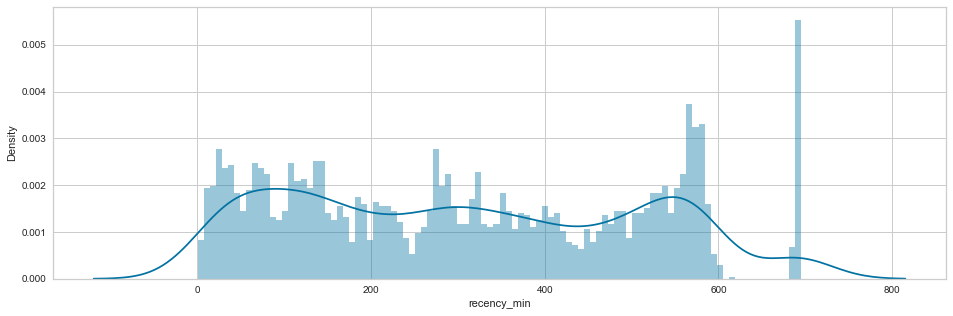

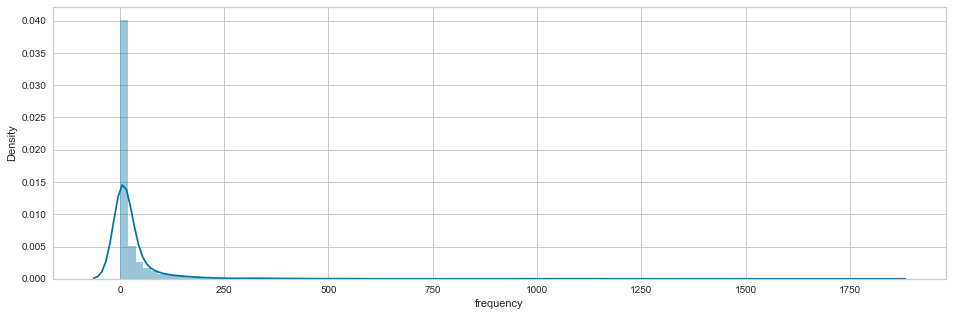

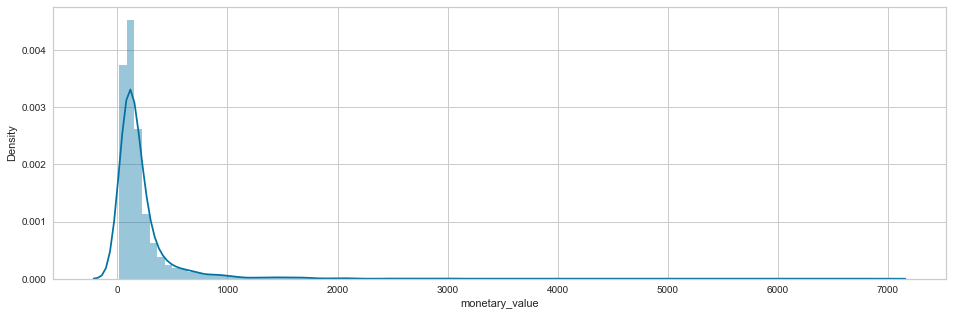

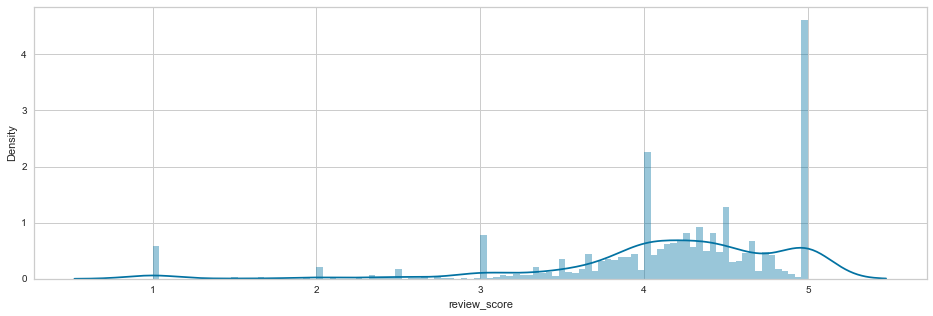

In [339]:
for col in seller.iloc[:,1:].columns:
    plt.figure(figsize=(16,5))
    sns.distplot(seller.iloc[:,1:][col], bins=100)
    plt.show()

Data is highly scewed. Will use data transformations(sqrt, box cox, log) later. K-means clustering works better with symmetrically distributed data

**Removing outlers**

In [340]:
# print(seller['recency_max'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
# print()
# print(seller['frequency'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
# print()
# print(seller['monetary_value'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

In [341]:
# upper_limit = np.percentile(seller['monetary_value'],95)

# seller = seller[seller['monetary_value'] <= upper_limit]
# seller.shape

In [342]:
# upper_limit = np.percentile(seller['frequency'],95)

# seller = seller[seller['frequency'] <= upper_limit]
# seller.shape

In [343]:
# upper_limit = np.percentile(seller['recency_max'],90)

# seller = seller[seller['recency_max'] <= upper_limit]
# seller.shape

In [344]:
# for col in seller.iloc[:,1:].columns:
#     plt.figure(figsize=(16,5))
#     sns.distplot(seller.iloc[:,1:][col], bins=100)
#     plt.show()

**Check for multicollinearity**

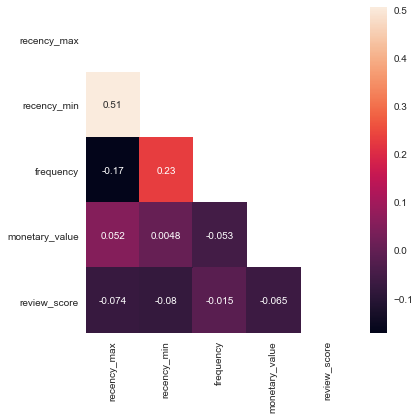

In [345]:
correlations_matrix = seller.iloc[:,1:].corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

There is no multicollinearity

**Defining dimentions for segmentation/clustering**

In [346]:
seller_preproces = seller.copy()

dimensions = ["recency_max", "frequency", "monetary_value"]

seller_preproces = seller_preproces[dimensions]

**Transformation**

In [347]:
def transformations (data, name):
    def log_transform(x):
        x = np.log(x)
        if np.isfinite(x):
            return x
        else:
            return 0

    data[name+"_sqrt"] = data[name]**(1/2)
    data[name+"_log"] = list(map(log_transform, data[name]))

    if data[name].min() > 0:
        box_cox, lmbda = stats.boxcox(data[name])
        data[name+"_bc"]= box_cox

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10,5)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.distplot(data[name], ax=ax1)
        sns.distplot(data[name+"_sqrt"], ax=ax2)
        sns.distplot(data[name+"_log"], ax=ax3)
        sns.distplot(data[name+"_bc"], ax=ax4)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.distplot(data[name], ax=ax1)
        sns.distplot(data[name+"_sqrt"], ax=ax2)
        sns.distplot(data[name+"_log"], ax=ax3)
    return

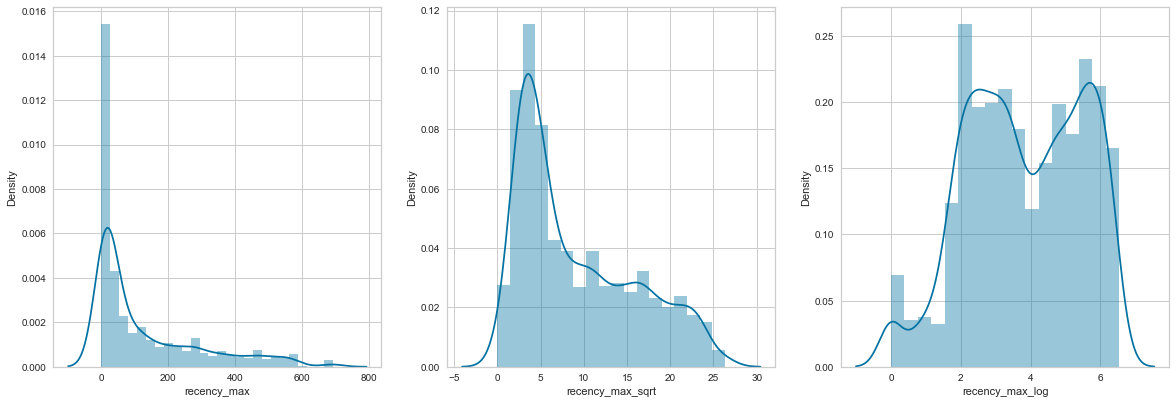

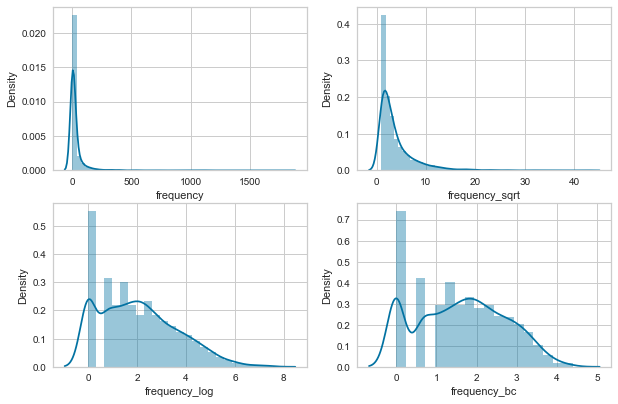

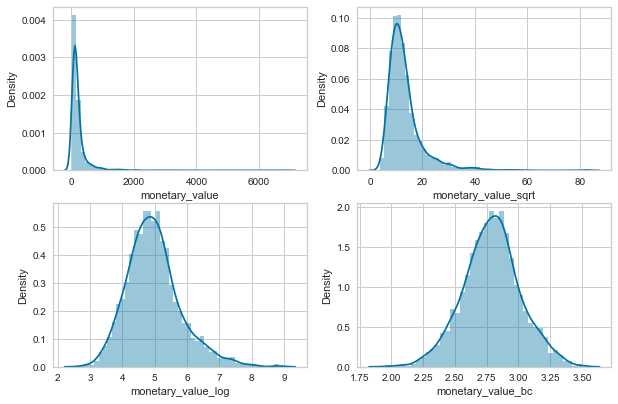

In [348]:
for col in seller_preproces.columns:
    transformations (seller_preproces, col)

In [349]:
seller_preproces = seller_preproces.drop(["recency_max","recency_max_sqrt","monetary_value", "monetary_value_sqrt", "monetary_value_log","frequency", "frequency_sqrt","frequency_log","review_score", "review_score_log","review_score_sqrt"], axis = 1, errors = "ignore")

In [350]:
seller_preproces.head()

,recency_max_log,frequency_bc,monetary_value_bc
0,5.752573,1.008078,3.226992
1,3.850148,3.570825,2.859596
2,4.934474,2.913443,2.419442
3,5.549076,0.000000,2.804167
4,4.770685,3.469658,2.822234


**Scaling**

In [351]:
seller_scaled = StandardScaler().fit_transform(seller_preproces)
seller_scaled = pd.DataFrame(seller_scaled)
seller_scaled.columns = dimensions
seller_scaled.head()

,recency_max,frequency,monetary_value
0,1.175052,-0.550768,1.935215
1,0.022411,1.774356,0.305132
2,0.679383,1.177928,-1.647762
3,1.051758,-1.465375,0.059206
4,0.580146,1.682570,0.139363


In [352]:
seller_scaled.isna().sum()

recency_max       0
frequency         0
monetary_value    0
dtype: int64

In [353]:
# seller_scaled = seller_scaled.dropna()
seller_scaled.shape

(2970, 3)

# ML Model for Segmentation 

## 1. K-means Clustering

**Findind the optimal number of clusters**

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9]')

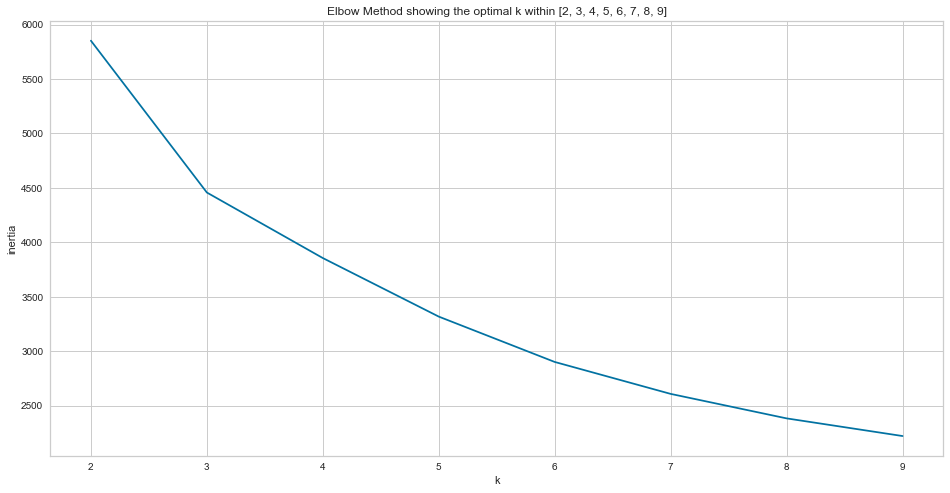

In [354]:
K = range(2,10)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(seller_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

Text(0.5, 1.0, 'Silhouette score showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9]')

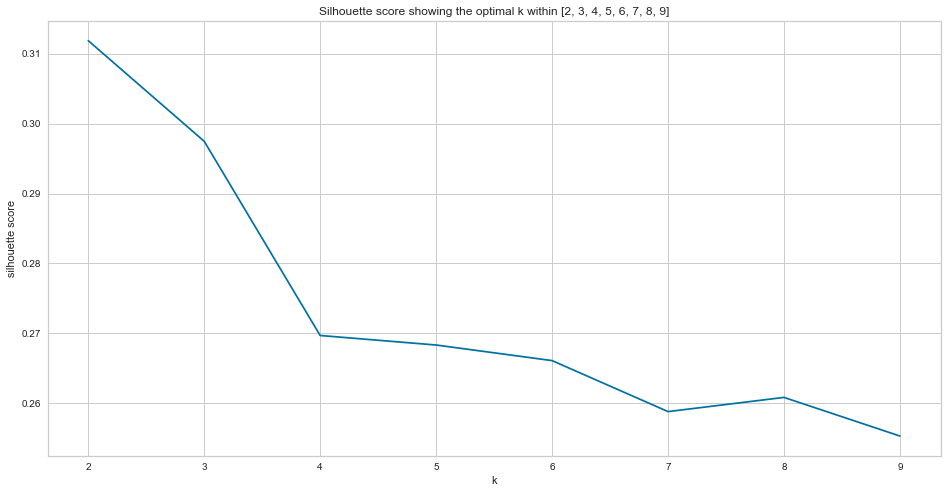

In [355]:
from sklearn.metrics import silhouette_score

K = range(2,10)
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(seller_scaled)
    silhouettes.append(silhouette_score(seller_scaled,
                                     kmeans.predict(seller_scaled)
                                    )
                   )

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Silhouette score showing the optimal k within {list(K)}')

The elbow method only uses intra-cluster distances while the silhouette method uses a combination of inter- and intra-cluster distances.

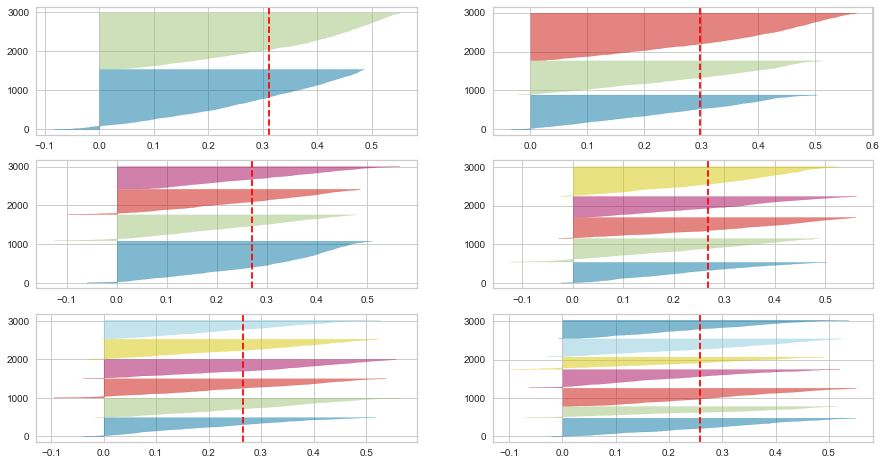

In [356]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for k in [2, 3, 4, 5,6,7]:
    km = KMeans(n_clusters=k,
                random_state=1234)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(seller_scaled)

k = 3 has the highest silhouette score and represents significally better quality of clusters. Will proceed with 3 clusters.

In [357]:
n_clusters = 3

**Fitting the model**

In [358]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++',
               random_state=1234).fit(seller_scaled)

clusters = kmeans.predict(seller_scaled)
    
seller_clustered = seller_scaled.copy()
seller_clustered['cluster_id'] = clusters

cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=seller_scaled.columns)
cluster_centers_df['cluster_id'] = range(0,n_clusters)

s_score = metrics.silhouette_score(seller_clustered, clusters)
print(f"Silhouette Score:  {s_score}")

Silhouette Score:  0.39741974184899936


**Visualizing the model performance**

<AxesSubplot:xlabel='recency_max', ylabel='frequency'>

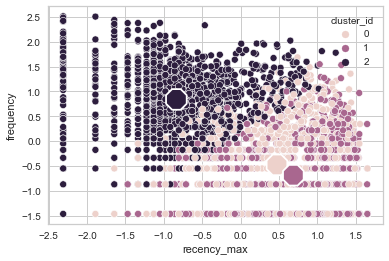

In [359]:
# plot datapoints
sns.scatterplot(data=seller_clustered,
               x=seller_clustered.columns[0],
               y=seller_clustered.columns[1],
               hue='cluster_id')

# plot centroids
sns.scatterplot(data=cluster_centers_df,
               x=seller_clustered.columns[0],
               y=seller_clustered.columns[1],
               hue='cluster_id',
                legend=False,
                marker=u'8',
                s=500,)

<AxesSubplot:xlabel='recency_max', ylabel='monetary_value'>

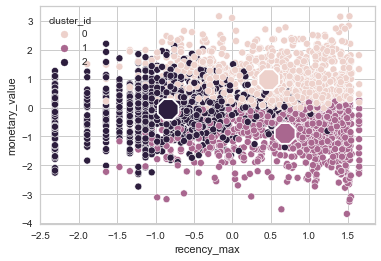

In [360]:
# plot datapoints
sns.scatterplot(data=seller_clustered,
               x=seller_clustered.columns[0],
               y=seller_clustered.columns[2],
               hue='cluster_id')

# plot centroids
sns.scatterplot(data=cluster_centers_df,
               x=seller_clustered.columns[0],
               y=seller_clustered.columns[2],
               hue='cluster_id',
                legend=False,
                marker=u'8',
                s=500,)

<AxesSubplot:xlabel='frequency', ylabel='monetary_value'>

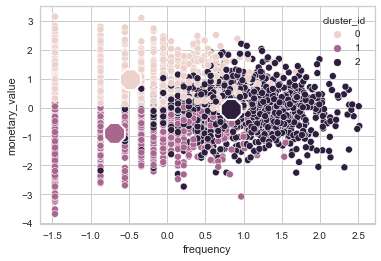

In [361]:
# plot datapoints
sns.scatterplot(data=seller_clustered,
               x=seller_clustered.columns[1],
               y=seller_clustered.columns[2],
               hue='cluster_id')

# plot centroids
sns.scatterplot(data=cluster_centers_df,
               x=seller_clustered.columns[1],
               y=seller_clustered.columns[2],
               hue='cluster_id',
                legend=False,
                marker=u'8',
                s=500,)

In [362]:
def plot_segm_3d (df):
    x = df[dimensions[0]]
    y = df[dimensions[1]]
    z = df[dimensions[2]]

    i = df["cluster_id"]

    # axes instance
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

    # plot
    sc = ax.scatter(x, y, z, s=40, c=i, marker='o', cmap = "viridis", alpha=1)
    ax.set_xlabel(dimensions[0])
    ax.set_ylabel(dimensions[1])
    ax.set_zlabel(dimensions[2])

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

    # save
    plt.savefig("scatter_hue", bbox_inches='tight')

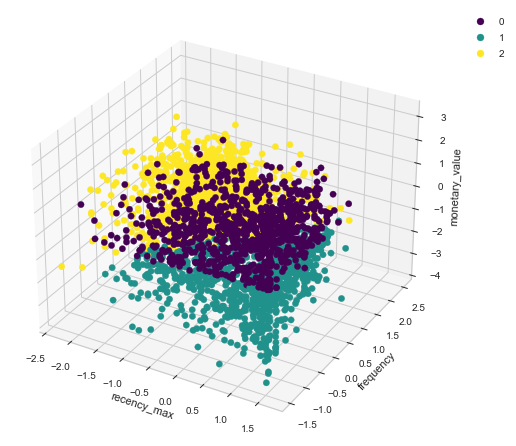

In [363]:
plot_segm_3d (seller_clustered)

**Adding segments to the initial dataframe (before scale and transform)** 

In [364]:
seller["cluster_id"] = clusters

In [365]:
seller.iloc[:,1:-1].head()

,recency_max,recency_min,frequency,monetary_value,review_score
0,315,336,3,916.020000,3.666667
1,47,570,195,170.404462,4.025641
2,139,349,50,43.392800,3.960000
3,257,257,1,139.380000,5.000000
4,118,579,155,148.647935,4.138710


**Analysing the results**

In [366]:
seller['cluster_id'].value_counts()

2    1215
0     887
1     868
Name: cluster_id, dtype: int64

In [367]:
segment0 = seller.iloc[:,1:-1][seller["cluster_id"]==0]
segment1 = seller.iloc[:,1:-1][seller["cluster_id"]==1]
segment2 = seller.iloc[:,1:-1][seller["cluster_id"]==2]
# segment3 = seller.iloc[:,1:-1][seller["cluster_id"]==3]
# segment4 = seller.iloc[:,1:-1][seller["cluster_id"]==4]

Segment0

recency_max       120.000000
recency_min       284.000000
frequency           3.000000
monetary_value    270.210000
review_score        4.285714
dtype: float64



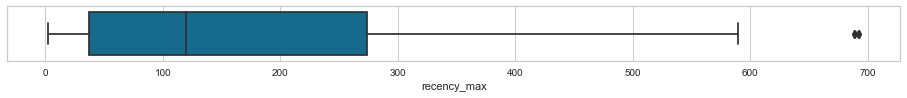

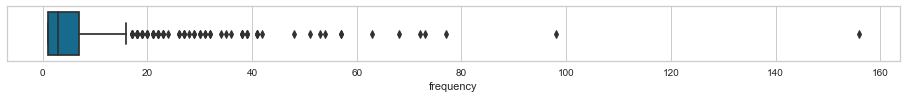

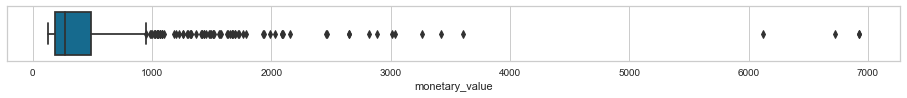

Segment1

recency_max       204.500000
recency_min       292.500000
frequency           2.000000
monetary_value     77.130317
review_score        4.458042
dtype: float64



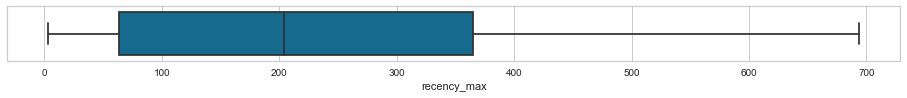

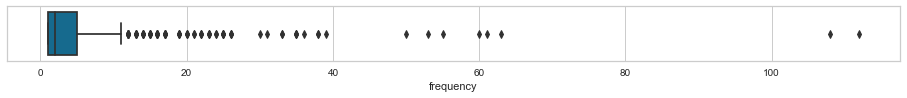

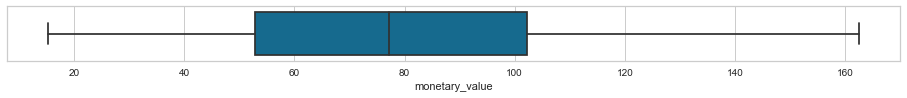

Segment2

recency_max        11.000000
recency_min       298.000000
frequency          27.000000
monetary_value    129.255270
review_score        4.214286
dtype: float64



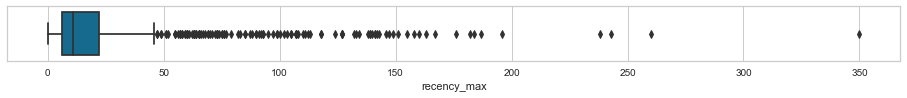

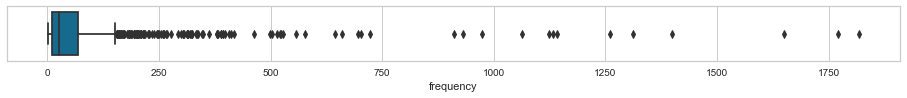

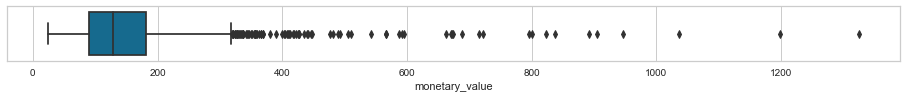

recency_max

Segment0


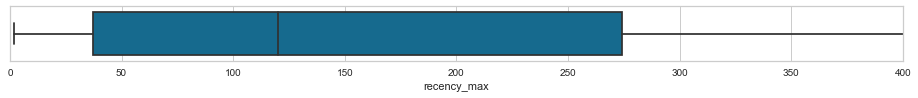


Segment1


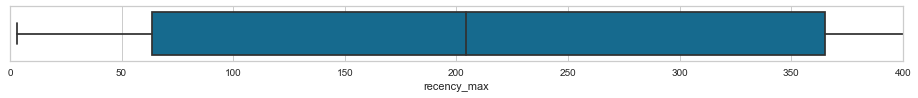


Segment2


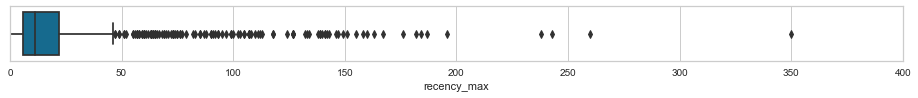

frequency

Segment0


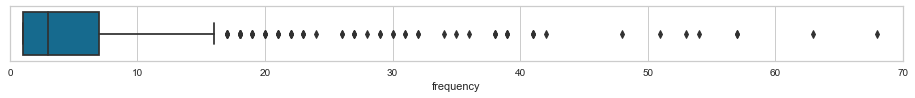


Segment1


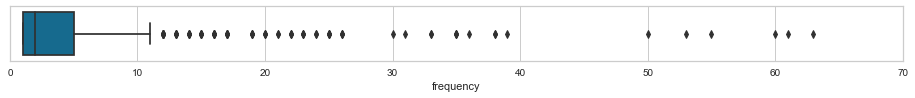


Segment2


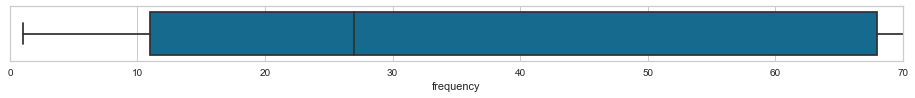

monetary_value

Segment0


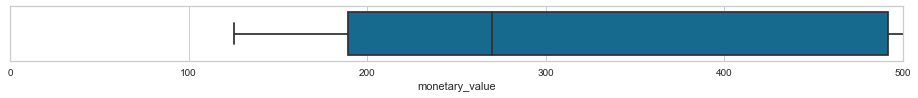


Segment1


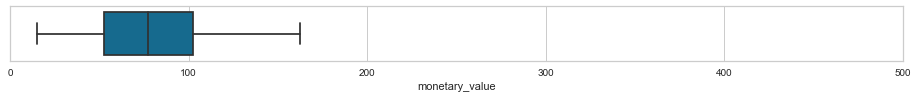


Segment2


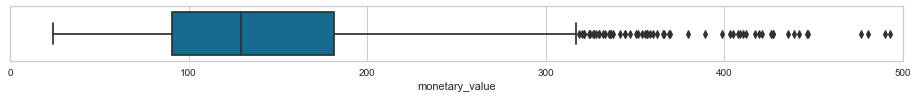

In [368]:
segments = [segment0, segment1, segment2]


for i, n in enumerate(segments):
    print(f"Segment{i}")
    print()
    print(n.median())
    print()
    for col in dimensions:
        plt.figure(figsize=(16,1))
        sns.boxplot(x=n[col])
        plt.show()
    
print(dimensions[0])    
for i, n in enumerate(segments):
    print()
    print(f"Segment{i}")
    plt.figure(figsize=(16,1))
    sns.boxplot(x=n[dimensions[0]])
    plt.xlim(0, 400)
    plt.show()
    
print(dimensions[1])    
for i, n in enumerate(segments):
    print()
    print(f"Segment{i}")
    plt.figure(figsize=(16,1))
    sns.boxplot(x=n[dimensions[1]])
    plt.xlim(0, 70)
    plt.show()
    
print(dimensions[2])    
for i, n in enumerate(segments):
    print()
    print(f"Segment{i}")
    plt.figure(figsize=(16,1))
    sns.boxplot(x=n[dimensions[2]])
    plt.xlim(0, 500)
    plt.show()

In [369]:
seller['cluster_name'] = 1
seller['cluster_name'][seller.cluster_id == 0] = "Opportunities"
seller['cluster_name'][seller.cluster_id == 1] = "Dogs"
seller['cluster_name'][seller.cluster_id == 2] = "Cows"

**Visualizing on actual data (before scale and transform)**

In [370]:
seller_test = seller.copy()

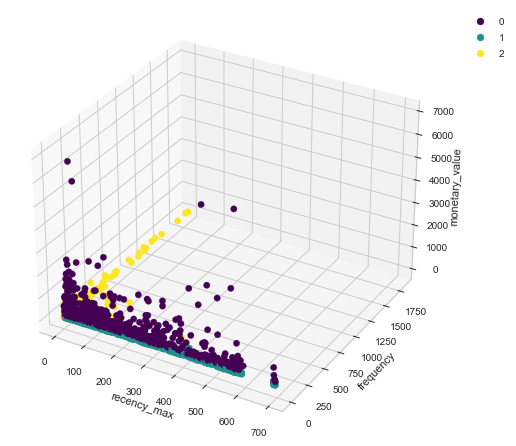

In [371]:
plot_segm_3d(seller_test)

## 2. DBSCAN - Density-Based Spatial Clustering

Define optimal eps (the most important parameter in DBSCAN model)

The detected knee point by this method is at distance 0.4655578806939187


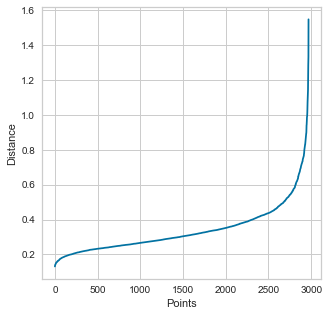

<Figure size 360x360 with 0 Axes>

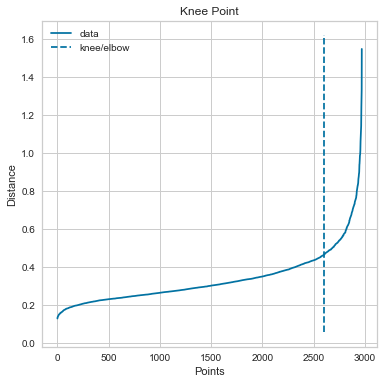

In [372]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(seller_scaled)
distances, indices = neighbors.kneighbors(seller_scaled)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(f"The detected knee point by this method is at distance {distances[knee.knee]}")

Now we can use this value as our eps to see how our new clustering would look like.

In [373]:
eps = distances[knee.knee]

dbscan = DBSCAN(eps=eps, min_samples=5).fit(seller_scaled)

clusters_db = dbscan.labels_

seller_clustered_dbscan = seller_scaled.copy()
seller_clustered_dbscan['cluster_id'] = clusters_db

# core_samples = np.zeros_like(clusters, dtype=bool)
# core_samples[dbscan.core_sample_indices_] = True
# print(core_samples)

n_clusters = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)
print(f"Number of clusers:  {n_clusters}")

s_score = metrics.silhouette_score(seller_scaled, clusters_db)
print(f"Silhouette Score:  {s_score}")

Number of clusers:  2
Silhouette Score:  0.2054382532285822


In [374]:
seller_clustered_dbscan["cluster_id"].value_counts()

 0    2382
 1     522
-1      66
Name: cluster_id, dtype: int64

Noisy samples are given the label -1.

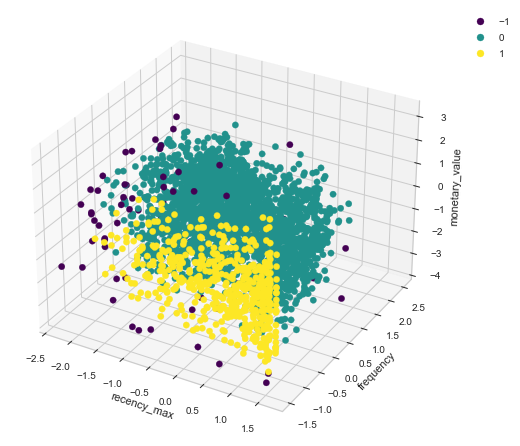

In [375]:
plot_segm_3d(seller_clustered_dbscan)

## 3. Mean Shift Clustering

In [376]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(seller_scaled, quantile=0.06, n_samples=900)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(seller_scaled)

clusters_ms = ms.labels_

# cluster_centers = ms.cluster_centers_

seller_clustered_ms = seller_scaled.copy()
seller_clustered_ms['cluster_id'] = clusters_ms

n_clusters_ = len(set(clusters_ms))

print(f"Number of clusers:  {n_clusters_}")

s_score = metrics.silhouette_score(seller_scaled, clusters_ms)
print(f"Silhouette Score:  {s_score}")

Number of clusers:  2
Silhouette Score:  0.3089410610245901


In [377]:
seller_clustered_ms['cluster_id'].value_counts()

1    1492
0    1478
Name: cluster_id, dtype: int64

In [ ]:
plot_segm_3d(seller_clustered_ms)

## 4. Agglomerative Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=3).fit(seller_scaled)
clustering
AgglomerativeClustering()
clusters_ag = clustering.labels_

seller_clustered_aggl = seller_scaled.copy()
seller_clustered_aggl['cluster_id'] = clusters_ag

n_clusters = len(set(clusters_ag))
print(f"Number of clusers:  {n_clusters}")

s_score = metrics.silhouette_score(seller_scaled, clusters_ag)
print(f"Silhouette Score:  {s_score}")

In [ ]:
seller_clustered_aggl['cluster_id'].value_counts()

In [ ]:
plot_segm_3d(seller_clustered_aggl)

# Conclusion

The highest Silhouette score was reached by K-means Clustering. 

Stick to the defined 3 clusters:

* Stars
* Dogs
* Dormant Opportunities

In [ ]:
seller.to_csv('csv_files/seller_segments005.csv', index=False)